In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/monet_jpg/f96a8de9f3.jpg
/kaggle/input/gan-getting-started/monet_jpg/79224da51f.jpg
/kaggle/input/gan-getting-started/monet_jpg/23832dead5.jpg
/kaggle/input/gan-getting-started/monet_jpg/85580214be.jpg
/kaggle/input/gan-getting-started/monet_jpg/47a0548067.jpg
/kaggle/input/gan-getting-started/monet_jpg/fb93438ff9.jpg
/kaggle/input/gan-getting-started/monet_jpg/89d970411d.jpg
/kaggle/input/gan-getting-started/monet_jpg/7960adbd50.j

In [2]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.10.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.10.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


In [3]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Input, Activation, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Add
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image
import io
from tensorflow.keras.layers import Dropout

In [4]:
#Preprocess Data
#Define image size
size = 256

def load_image(image_path):
    img = load_img(image_path, target_size=(size,size))
    return img_to_array(img) / 255.0

def preprocess_dataset(path):
    images = []
    for img_path in os.listdir(path):
        img = load_image(os.path.join(path, img_path))
        images.append(img)
    return tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(1)

monet_dataset = preprocess_dataset('/kaggle/input/gan-getting-started/monet_jpg')
photo_dataset = preprocess_dataset('/kaggle/input/gan-getting-started/photo_jpg')


In [5]:
def build_discriminator():
    inputs = Input(shape=[256, 256, 3])  # Input for 256x256 images

    # Layer 1: Convolution + LeakyReLU
    x = Conv2D(64, kernel_size=4, strides=2, padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    # Layer 2: Convolution + BatchNorm + LeakyReLU
    x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Layer 3: Convolution + BatchNorm + LeakyReLU + Dropout
    x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Layer 4: Convolution + BatchNorm + LeakyReLU + Dropout
    x = Conv2D(512, kernel_size=4, strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output layer: PatchGAN-like map
    x = Conv2D(1, kernel_size=4, strides=1, padding="same")(x)
    outputs = Activation('sigmoid')(x)  # Optional for probability output

    return Model(inputs=inputs, outputs=outputs)

discriminator_x = build_discriminator()
discriminator_y = build_discriminator()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [6]:



def build_generator(num_residual_blocks=9):
    """
    Build a generator model for CycleGAN with 9 residual blocks.
    """
    inputs = Input(shape=[size, size, 3])

    # Downsampling
    x = Conv2D(64, kernel_size=7, strides=1, padding='same', use_bias=False, kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual Blocks
   # for _ in range(num_residual_blocks):
    #    x = residual_block(x, 256)

    # Upsampling
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Output Layer
    outputs = Conv2D(3, kernel_size=7, strides=1, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

generator_g = build_generator()
generator_f = build_generator()



In [7]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_y = generator_g(real_x, training=True)
        fake_x = generator_f(real_y, training=True)

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Loss calculations
        gen_g_loss = loss_obj(tf.ones_like(disc_fake_y), disc_fake_y)
        gen_f_loss = loss_obj(tf.ones_like(disc_fake_x), disc_fake_x)
        total_gen_loss = gen_g_loss + gen_f_loss

        disc_x_loss = loss_obj(tf.ones_like(disc_real_x), disc_real_x) + \
                      loss_obj(tf.zeros_like(disc_fake_x), disc_fake_x)
        disc_y_loss = loss_obj(tf.ones_like(disc_real_y), disc_real_y) + \
                      loss_obj(tf.zeros_like(disc_fake_y), disc_fake_y)
        total_disc_loss = disc_x_loss + disc_y_loss

    # Apply gradients to the Generator
    gen_gradients = tape.gradient(total_gen_loss,
                                  generator_g.trainable_variables + generator_f.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_gradients,
                                      generator_g.trainable_variables + generator_f.trainable_variables))

    # Apply gradients to the Discriminators
    disc_gradients = tape.gradient(total_disc_loss,
                                   discriminator_x.trainable_variables + discriminator_y.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_gradients,
                                       discriminator_x.trainable_variables + discriminator_y.trainable_variables))

In [8]:
# Number of epochs
num_epochs = 20

for epoch in range(1, num_epochs + 1):
    # Display a progress bar for each batch in the epoch
    for real_x, real_y in tqdm(tf.data.Dataset.zip((photo_dataset, monet_dataset)), desc=f"Epoch {epoch}", unit="batch"):
        train_step(real_x, real_y)
    
    print(f"Epoch {epoch} completed")

Epoch 1:   0%|          | 0/300 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:674: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
Epoch 1: 100%|██████████| 300/300 [00:55<00:00,  5.36batch/s]


Epoch 1 completed


Epoch 2: 100%|██████████| 300/300 [00:40<00:00,  7.32batch/s]


Epoch 2 completed


Epoch 3: 100%|██████████| 300/300 [00:41<00:00,  7.21batch/s]


Epoch 3 completed


Epoch 4: 100%|██████████| 300/300 [00:41<00:00,  7.26batch/s]


Epoch 4 completed


Epoch 5: 100%|██████████| 300/300 [00:41<00:00,  7.21batch/s]


Epoch 5 completed


Epoch 6: 100%|██████████| 300/300 [00:41<00:00,  7.25batch/s]


Epoch 6 completed


Epoch 7: 100%|██████████| 300/300 [00:41<00:00,  7.24batch/s]


Epoch 7 completed


Epoch 8: 100%|██████████| 300/300 [00:41<00:00,  7.25batch/s]


Epoch 8 completed


Epoch 9: 100%|██████████| 300/300 [00:41<00:00,  7.24batch/s]


Epoch 9 completed


Epoch 10: 100%|██████████| 300/300 [00:41<00:00,  7.26batch/s]


Epoch 10 completed


Epoch 11: 100%|██████████| 300/300 [00:41<00:00,  7.22batch/s]


Epoch 11 completed


Epoch 12: 100%|██████████| 300/300 [00:41<00:00,  7.23batch/s]


Epoch 12 completed


Epoch 13: 100%|██████████| 300/300 [00:41<00:00,  7.24batch/s]


Epoch 13 completed


Epoch 14: 100%|██████████| 300/300 [00:41<00:00,  7.24batch/s]


Epoch 14 completed


Epoch 15: 100%|██████████| 300/300 [00:41<00:00,  7.25batch/s]


Epoch 15 completed


Epoch 16: 100%|██████████| 300/300 [00:41<00:00,  7.23batch/s]


Epoch 16 completed


Epoch 17: 100%|██████████| 300/300 [00:41<00:00,  7.23batch/s]


Epoch 17 completed


Epoch 18: 100%|██████████| 300/300 [00:41<00:00,  7.24batch/s]


Epoch 18 completed


Epoch 19: 100%|██████████| 300/300 [00:41<00:00,  7.23batch/s]


Epoch 19 completed


Epoch 20: 100%|██████████| 300/300 [00:41<00:00,  7.24batch/s]

Epoch 20 completed


In [9]:

# Function to generate and display a transformed image
def generate_image(generator, image, title="Generated Image"):
    fake_image = generator(image, training=False)  # Ensure training=False for inference
    plt.figure(figsize=(4, 4))
    plt.imshow(fake_image[0] * 0.5 + 0.5)  # Rescale pixel values from [-1, 1] to [0, 1]
    plt.axis('off')
    plt.title(title)
    plt.show()


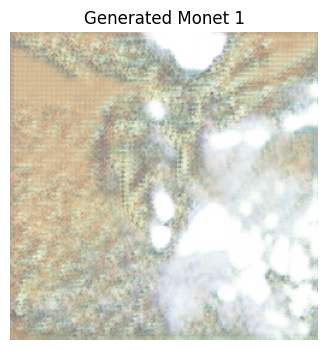

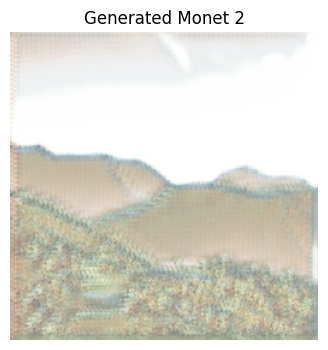

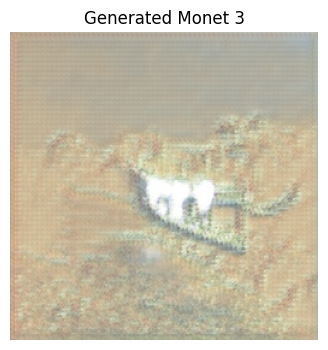

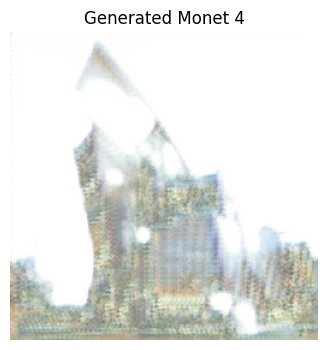

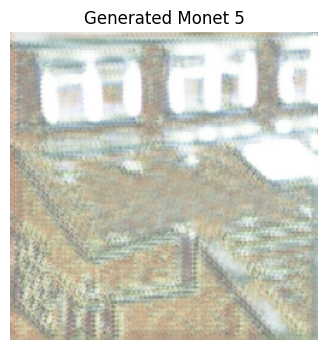

In [10]:
# Generate and display fake images for the first 5 images in the dataset
for i, photo in enumerate(photo_dataset.take(5)):
    generate_image(generator_g, photo, title=f"Generated Monet {i+1}")


In [11]:

# Define constants
NUM_IMAGES = 7000  # Number of Monet-style images you want to generate
IMAGE_SIZE = (256, 256)  # Required image size (256x256)
ZIP_FILE_NAME = 'images.zip'

# Initialize the ZIP file
with zipfile.ZipFile(ZIP_FILE_NAME, 'w') as zipf:
    for i, photo in enumerate(photo_dataset.take(NUM_IMAGES)):
        # Generate the Monet-style image
        fake_image = generator_g(photo, training=False)[0]  # Get the first image in the batch

        # Rescale the image from [-1, 1] to [0, 255] and convert to uint8
        fake_image = (fake_image * 127.5 + 127.5).numpy().astype('uint8')

        # Convert the generated image to JPG format
        img_pil = Image.fromarray(fake_image)
        img_pil = img_pil.resize(IMAGE_SIZE)  # Ensure the image is 256x256

        # Save the image to a byte buffer
        img_buffer = io.BytesIO()
        img_pil.save(img_buffer, format="JPEG")

        # Write the image to the ZIP file
        zipf.writestr(f"monet_image_{i+1}.jpg", img_buffer.getvalue())

        # Optional: Print progress every 1000 images
        if (i + 1) % 1000 == 0:
            print(f"{i + 1} images generated and added to zip file.")

print("All images generated and saved to images.zip.")


1000 images generated and added to zip file.
2000 images generated and added to zip file.
3000 images generated and added to zip file.
4000 images generated and added to zip file.
5000 images generated and added to zip file.
6000 images generated and added to zip file.
7000 images generated and added to zip file.
All images generated and saved to images.zip.
